# Training Loops

In [36]:
from matplotlib import pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = [9,6]

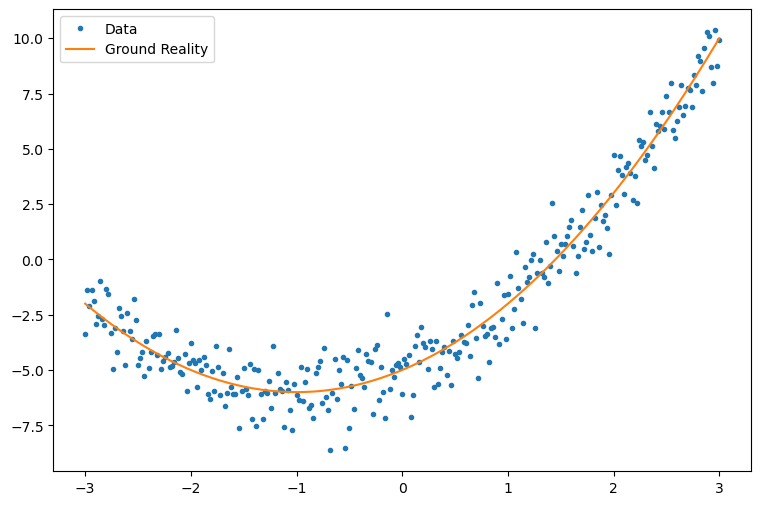

In [93]:
import tensorflow as tf

x = tf.linspace(-3, 3, 301)
x = tf.cast(x, tf.float32)

def f(x):
    y = x**2 + 2*x - 5
    return y

y = f(x) + tf.random.normal(shape=[301])

plt.plot(x.numpy(), y.numpy(), '.', label='Data')
plt.plot(x, f(x), label='Ground Reality')
plt.legend()

## Create a Quadratic Model
With random weights initializations

In [96]:
class QuadModel(tf.Module):
    def __init__(self):
        # Randomly generate weight and bias terms
        rand_init = tf.random.uniform(shape=[3], minval=0., maxval=5., seed=22)
        
        self.w_q = tf.Variable(rand_init[2])
        self.w_1 = tf.Variable(rand_init[1])
        self.w_0 = tf.Variable(rand_init[0])
    
    @tf.function
    def __call__(self, x):
        # Quadratic Model : quadratic_weight * x^2 + linear_weight * x + bias
        y_ = self.w_q*(x**2) + self.w_1*x + self.w_0
        return y_

In [97]:
def plot_preds(x, y, f, model, title ):
    plt.figure()
    plt.plot(x.numpy(), y.numpy(), '*', label = 'Data points')
    plt.plot(x, f(x), label='Underlying Model')
    plt.plot(x, model(x), label='Predictions')
    plt.title(title)
    plt.legend()

2023-07-08 21:41:26.292292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


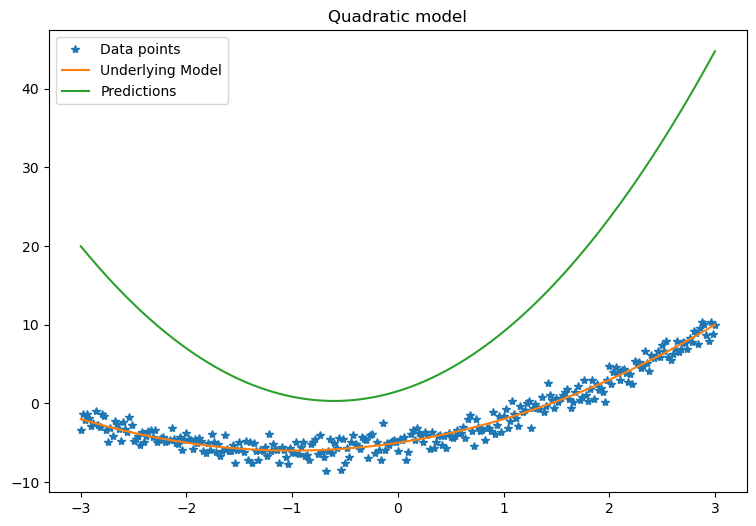

In [98]:
quad_model = QuadModel()
plot_preds(x,y, f, quad_model, "Quadratic model")

In [99]:
# DEFINE LOSE FUNCTION
def mse_loss(y_pred, y):
    return tf.reduce_mean(tf.square(y_pred-y))

In [100]:
mse_loss(y, quad_model(x))

<tf.Tensor: shape=(), dtype=float32, numpy=250.79863>

In [101]:
quad_model.variables

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.5589648>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=4.131706>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.424728>)

In [107]:
dataset = tf.data.Dataset.from_tensor_slices((x,y))
dataset = dataset.shuffle(buffer_size=x.shape[0])
dataset = dataset.batch(batch_size)

In [115]:
epochs = 100
learning_rate = 0.02
losses = []
for epoch in range(epochs):
    for x_batch, y_batch in dataset:
        with tf.GradientTape() as tape:
            batch_loss = mse_loss(quad_model(x_batch), y_batch)
        grads = tape.gradient(batch_loss, quad_model.variables)
        for _grad, _var in zip(grads,quad_model.variables):
            _var.assign_sub(_grad*learning_rate) #subtracts given number from the current value and reassigns
    epoch_loss = mse_loss(quad_model(x_batch), y_batch)
    losses.append(epoch_loss)
    if epoch%10==0:
        print("MSE loss for epoch {} is {}".format(epoch, epoch_loss))

2023-07-08 21:59:11.335952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-08 21:59:11.436270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-08 21:59:11.460544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


MSE loss for epoch 0 is 6.6484270095825195
MSE loss for epoch 10 is 0.9418895840644836
MSE loss for epoch 20 is 0.4961174726486206
MSE loss for epoch 30 is 0.8665676712989807
MSE loss for epoch 40 is 1.0047396421432495
MSE loss for epoch 50 is 1.1031793355941772
MSE loss for epoch 60 is 0.9336574673652649
MSE loss for epoch 70 is 0.8549752235412598
MSE loss for epoch 80 is 0.5159783959388733
MSE loss for epoch 90 is 0.560470700263977


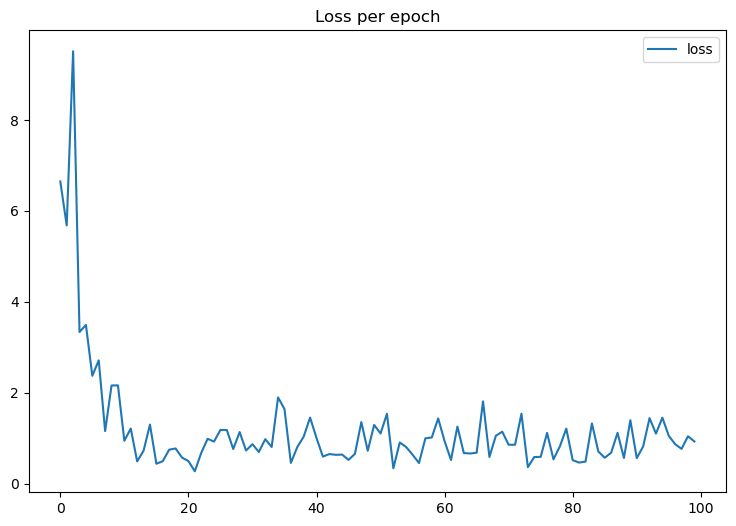

In [117]:
plt.figure()
plt.plot(range(epochs), losses, label='loss')
plt.title("Loss per epoch")
plt.legend()

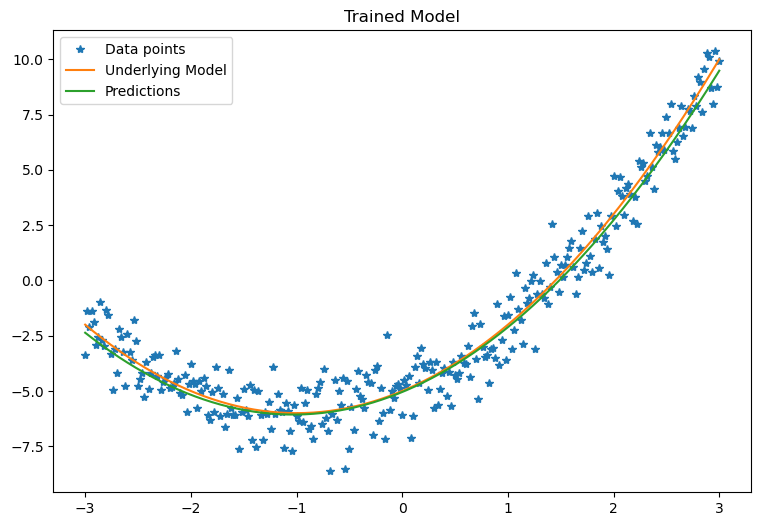

In [119]:
plot_preds(x, y, f, quad_model, "Trained Model")

In [137]:
class QuadModel(tf.Module):
    def __init__(self, random_state:int=32, learning_rate:float=0.02):
        self.lr = learning_rate
        self.weights = tf.random.uniform(shape=[3], minval=2, maxval=5, seed=random_state)
        
        self.w_0 = tf.Variable(self.weights[0])
        self.w_1 = tf.Variable(self.weights[1])
        self.w_q = tf.Variable(self.weights[2])
        
        self.loss_history = []
    
    @tf.function
    def __call__(self, x):
        return self.w_q*(x**2) + self.w_1*x + self.w_0
    
    def mse_loss(self, y_pred, y):
        return tf.reduce_mean(tf.square(y_pred-y))
    
    def fit(self, x, y, batch_size=32, epochs=100, verbose=True):
        dataset = tf.data.Dataset.from_tensor_slices((x, y))
        dataset = dataset.shuffle(buffer_size=x.shape[0]).batch(batch_size=batch_size)
        
        for epoch in range(epochs):
            for x_batch, y_batch in dataset:
                
                with tf.GradientTape() as tape:
                    batch_loss = self.mse_loss(self.__call__(x_batch), y_batch)
                grads = tape.gradient(batch_loss, self.variables)
                
                for g, v in zip(grads, self.variables):
                    v.assign_sub(g*self.lr)
                    
            batch_loss = self.mse_loss(self.__call__(x), y)
            self.loss_history.append(batch_loss)
            if verbose and epoch%10==0:
                print("Epoch {} -> Loss: {}".format(epoch, batch_loss))
        return
        
        

In [141]:
model = QuadModel()
model.fit(x, y, epochs=25)

2023-07-08 22:49:13.311364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-08 22:49:13.328833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-08 22:49:13.397130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-08 22:49:13.415676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-08 22:49:13.446851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 0 -> Loss: 21.02370262145996
Epoch 10 -> Loss: 1.4886348247528076
Epoch 20 -> Loss: 0.9578070640563965


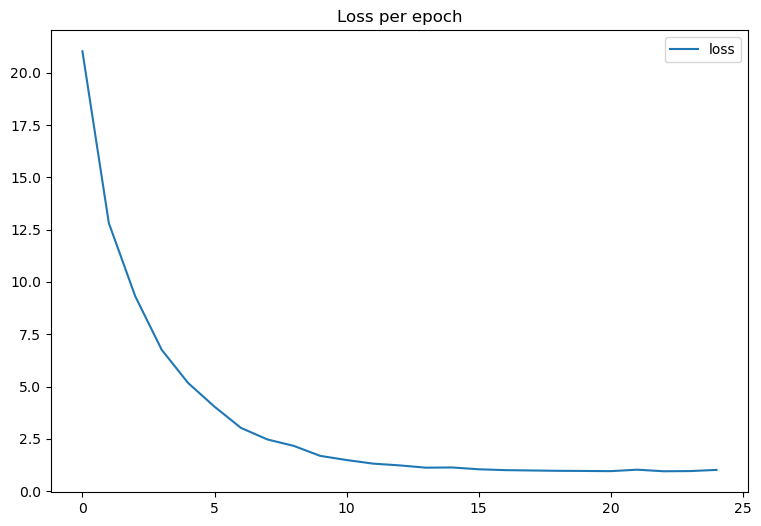

In [143]:
plt.figure()
plt.plot(range(25), model.loss_history, label='loss')
plt.title("Loss per epoch")
plt.legend()

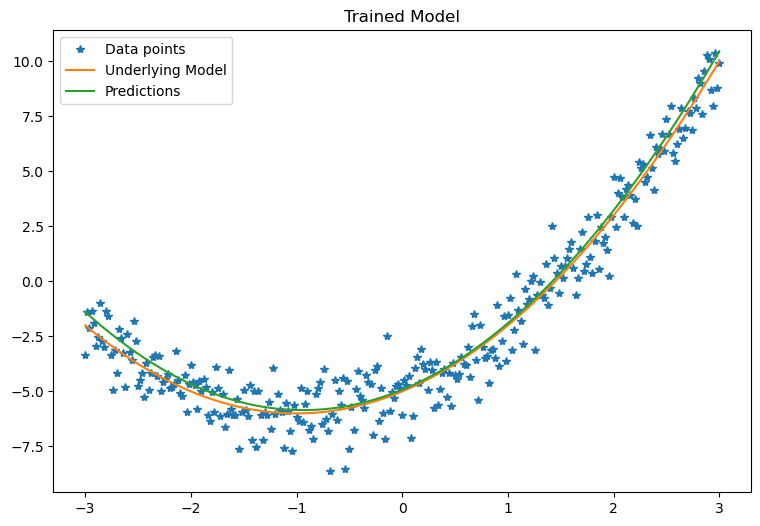

In [144]:
plot_preds(x, y, f, model, "Trained Model")